# Try out framework with simulated data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import torch
from q2_ritme.process_data import load_n_split_data
from q2_ritme.tune_models import run_all_trials
from q2_ritme.evaluate_models import get_best_model, get_best_data_processing
from q2_ritme.feature_space.transform_features import transform_features
from q2_ritme.config import (
    HOST_ID,
    TARGET,
    SEED_DATA,
    SEED_MODEL,
    MLFLOW_TRACKING_URI,
)
from q2_ritme.model_space._static_trainables import NeuralNet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# 30.437 is avg. number of days per month
DAYS_PER_MONTH = 30.437
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
ls_model_types = ["nn", "xgb", "linreg", "rf"]

## Load and split data

In [3]:
train_val, test = load_n_split_data()

Train: (75, 22), Test: (25, 22)


## Run all experiments

In [4]:
result_dic = run_all_trials(
    train_val,
    TARGET,
    HOST_ID,
    SEED_DATA,
    SEED_MODEL,
    MLFLOW_TRACKING_URI,
    model_types=ls_model_types,
    fully_reproducible=False,
)
result_dic

(train_rf pid=45352) Train: (48, 21), Test: (27, 21) [repeated 4x across cluster]


2024-02-16 17:13:39,525	INFO tune.py:1148 -- Total run time: 11.84 seconds (11.79 seconds for the tuning loop).


{'nn': ResultGrid<[
   Result(
     metrics={'rmse_val': 1751.5662841796875, 'rmse_train': 264.1811828613281, 'should_checkpoint': True, 'done': True, 'trial_id': '35278_00000', 'experiment_tag': '0_batch_size=128,data_alr_denom_idx=11,data_transform=None,epochs=200,learning_rate=0.0312,n_hidden_layers=9,n_units_hl0=6,n_units_hl1=15,n_units_hl10=14,n_units_hl11=57,n_units_hl2=51,n_units_hl3=25,n_units_hl4=52,n_units_hl5=55,n_units_hl6=8,n_units_hl7=16,n_units_hl8=28,n_units_hl9=37'},
     path='/Users/anjaadamov/Documents/projects/14_LM1/q2-ritme/experiments/best_models/nn/train_nn_35278_00000_0_batch_size=128,data_alr_denom_idx=11,data_transform=None,epochs=200,learning_rate=0.0312,n_hidden_layers=9,_2024-02-16_17-12-45',
     checkpoint=Checkpoint(local_path=/Users/anjaadamov/Documents/projects/14_LM1/q2-ritme/experiments/best_models/nn/train_nn_35278_00000_0_batch_size=128,data_alr_denom_idx=11,data_transform=None,epochs=200,learning_rate=0.0312,n_hidden_layers=9,_2024-02-16_17-12-4

## Evaluate best models

In [5]:
class TunedModel:
    def __init__(self, model, data_config):
        self.model = model
        self.data_config = data_config

    def transform(self, data):
        transformed = transform_features(
            data,
            self.data_config["data_transform"],
            self.data_config["data_alr_denom_idx"],
        )
        if isinstance(self.model, xgb.core.Booster):
            return xgb.DMatrix(transformed)
        elif isinstance(self.model, NeuralNet):
            return torch.tensor(transformed.values, dtype=torch.float32)
        else:
            return transformed.values

    def predict(self, data):
        transformed = self.transform(data)
        if isinstance(self.model, NeuralNet):
            with torch.no_grad():
                predicted = self.model(transformed).numpy()
        else:
            predicted = self.model.predict(transformed)
        return predicted.flatten()

In [6]:
best_model_dic = {}
for model_type, result_grid in result_dic.items():
    best_model = get_best_model(model_type, result_grid)
    best_data_proc = get_best_data_processing(result_grid)

    best_model_dic[model_type] = TunedModel(best_model, best_data_proc)

best_model_dic

{'nn': <__main__.TunedModel at 0x7fa33b904f10>,
 'xgb': <__main__.TunedModel at 0x7fa33b5bf850>,
 'linreg': <__main__.TunedModel at 0x7fa33ba85a60>,
 'rf': <__main__.TunedModel at 0x7fa33bcacf10>}

In [7]:
# ! Perform predictions with best model
def save_predictions(data, tmodel, target, features, split=None):
    # id, true
    saved_pred = data[[target]].copy()
    saved_pred.rename(columns={target: "true"}, inplace=True)
    # pred, split
    saved_pred["pred"] = tmodel.predict(data[features])
    saved_pred["split"] = split
    return saved_pred


non_features = [TARGET, HOST_ID]
features = [x for x in train_val if x not in non_features]

# dic with model_type: df with all predictions within
preds_dic = {}
for model_type, tmodel in best_model_dic.items():
    train_df = save_predictions(train_val, tmodel, TARGET, features, "train")
    test_pred = save_predictions(test, tmodel, TARGET, features, "test")

    preds_dic[model_type] = pd.concat([train_df, test_pred])

<AxesSubplot: title={'center': 'Overall'}, ylabel='RMSE'>

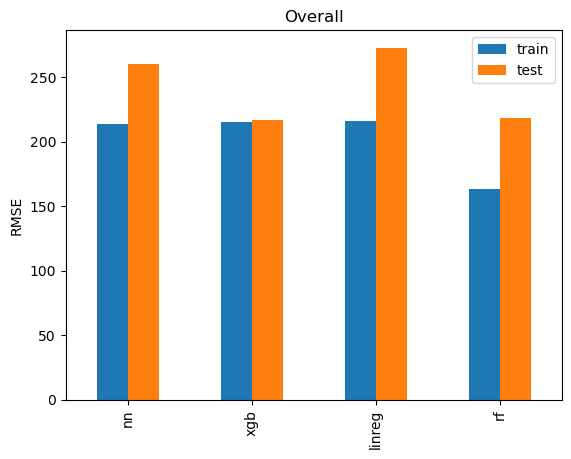

In [8]:
# plot rmse over all experiments # !(OVERALL case)
def _calculate_rmse(pred_df):
    rmse_scores = {}
    for split in pred_df["split"].unique():
        pred_split = pred_df[pred_df["split"] == split].copy()
        rmse = mean_squared_error(
            pred_split["true"].values, pred_split["pred"].values, squared=False
        )
        rmse_scores[split] = rmse
    return rmse_scores


rmse_dic = {}
for model_type, pred_df in preds_dic.items():
    # todo: add a bin_by variable (for "over time" and "over study")
    rmse_dic[model_type] = _calculate_rmse(pred_df)

rmse_df = pd.DataFrame(rmse_dic).T
rmse_df.plot(kind="bar", title="Overall", ylabel="RMSE")

<AxesSubplot: title={'center': 'Model: nn'}, xlabel='group', ylabel='RMSE'>

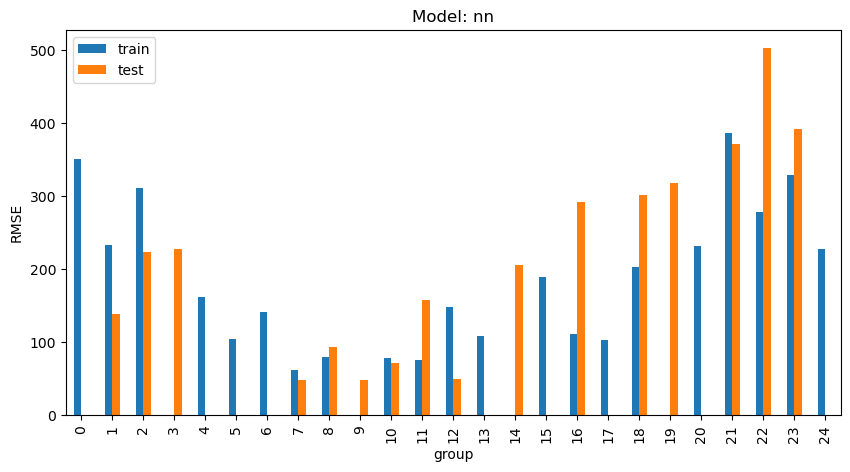

In [9]:
# plot rmse over true time bin
# ! (TIME case)
model_type = ls_model_types[0]
pred_df = preds_dic[model_type]
split = None

# bin true columns by months
pred_df["group"] = np.round(pred_df["true"] / DAYS_PER_MONTH, 0).astype(int)

grouped_ser = pred_df.groupby(["group"]).apply(_calculate_rmse)
grouped_df = grouped_ser.apply(pd.Series)
if split is not None:
    grouped_df = grouped_df[[split]].copy()

grouped_df.plot(
    kind="bar", title=f"Model: {model_type}", ylabel="RMSE", figsize=(10, 5)
)

## Compare experiments

In [10]:
def get_best_model(exp_name, trial_result, metric_ls=["rmse_train", "rmse_val"]):
    # Get the result with the metric and mode defined in tune_config before
    best_result = trial_result.get_best_result()
    config = best_result.config

    # # get config of best model
    # best_result.config

    metrics_ser = best_result.metrics_dataframe[metric_ls].iloc[-1]
    metrics_df = pd.DataFrame({exp_name: metrics_ser})
    return metrics_df, config


def calc_best_metrics(dic_trials):
    df_metrics = pd.DataFrame(index=["rmse_train", "rmse_val"])
    dic_config = {}
    for key, value in dic_trials.items():
        df_best, config = get_best_model(key, value)
        df_metrics = df_metrics.join(df_best)
        dic_config[key] = config

    return df_metrics, pd.DataFrame(dic_config)


def plot_best_metrics(df_metrics):
    df2plot = df_metrics.T.sort_values("rmse_val", ascending=True)
    df2plot.columns = ["train", "validation"]
    # plot settings
    # todo: set default plot settings across package
    plt.style.use("seaborn-v0_8-colorblind")  # ("tableau-colorblind10")
    titlesize = 14
    labelsize = 13
    ticklabel = 12
    plt.rcParams.update({"font.size": labelsize})

    df2plot.plot(kind="bar", figsize=(12, 6))

    plt.xticks(fontsize=ticklabel)
    plt.yticks(fontsize=ticklabel)
    plt.ylabel("RMSE", fontsize=labelsize)
    plt.xlabel("Model type (order: increasing val score)", fontsize=labelsize)
    plt.title("Metrics comparison", fontsize=titlesize)
    plt.show()

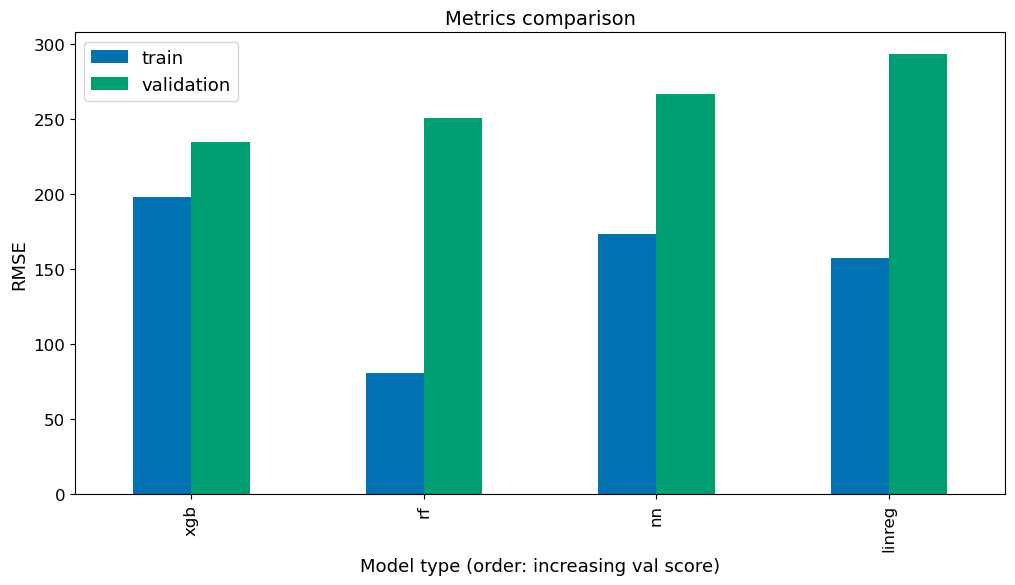

,nn,xgb,linreg,rf
data_transform,ilr,alr,None,alr
data_alr_denom_idx,16,2,11,3
n_hidden_layers,6,NaN,NaN,NaN
learning_rate,0.001789,NaN,NaN,NaN
batch_size,64,NaN,NaN,NaN
epochs,50,NaN,NaN,NaN
n_units_hl0,48,NaN,NaN,NaN
n_units_hl1,33,NaN,NaN,NaN
n_units_hl2,51,NaN,NaN,NaN
n_units_hl3,35,NaN,NaN,NaN


In [11]:
dic_all = {}
# todo: check something in the below plot is very wrong!
for model_type in ls_model_types:
    dic_all[model_type] = result_dic[model_type]
metrics_all, best_configs = calc_best_metrics(dic_all)
plot_best_metrics(metrics_all)
display(best_configs)

In [12]:
def _highlight_differing_cols(x):
    """
    Function returning color map of differing columns in x
    Original code used as base:
    https://stackoverflow.com/questions/41654949/pandas-style-function-to-highlight-specific-columns
    """
    # copy df to new - original data is not changed
    df = x.copy()

    # extract list of columns that differ between all models
    ls_col = df.columns[df.nunique(dropna=False) > 1].tolist()

    # select default neutral background
    df.loc[:, :] = "background-color: None"

    # mark columns that differ
    df[ls_col] = "color: red"

    # return colored df
    return df


best_configs.style.apply(_highlight_differing_cols, axis=None)

,nn,xgb,linreg,rf
data_transform,ilr,alr,None,alr
data_alr_denom_idx,16,2,11,3
n_hidden_layers,6,nan,nan,nan
learning_rate,0.001789,nan,nan,nan
batch_size,64,nan,nan,nan
epochs,50,nan,nan,nan
n_units_hl0,48,nan,nan,nan
n_units_hl1,33,nan,nan,nan
n_units_hl2,51,nan,nan,nan
n_units_hl3,35,nan,nan,nan


## Evaluate over training time (example for nn model here)

<AxesSubplot: xlabel='training_iteration'>

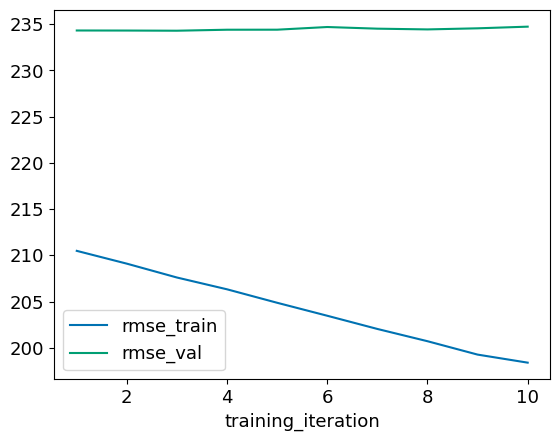

In [13]:
# Get the result with the maximum test set `mean_accuracy`
best_xgb = result_dic["xgb"].get_best_result()
best_xgb.metrics_dataframe.plot("training_iteration", ["rmse_train", "rmse_val"])

Text(0, 0.5, 'RMSE_val')

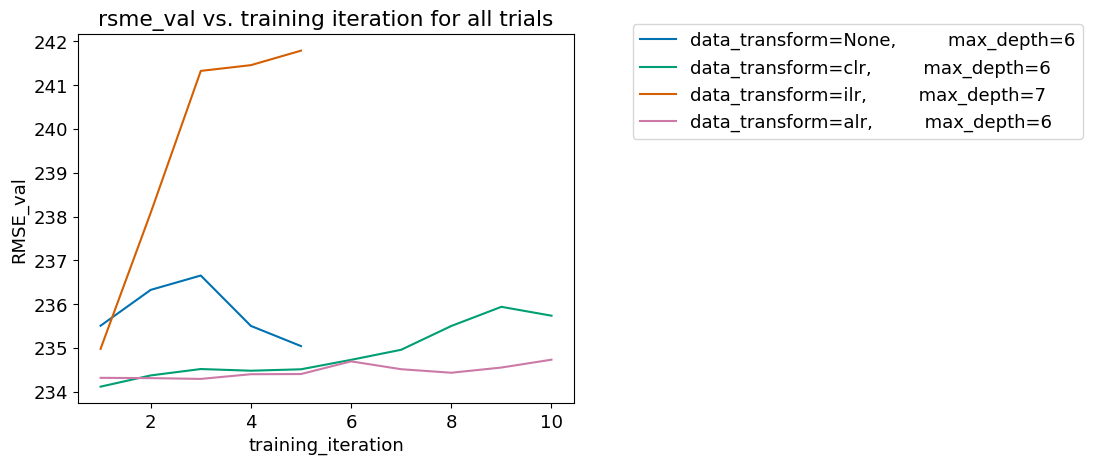

In [14]:
ax = None
for result in result_dic["xgb"]:
    label = f"data_transform={result.config['data_transform']}, \
        max_depth={result.config['max_depth']}"
    if ax is None:
        ax = result.metrics_dataframe.plot(
            "training_iteration", "rmse_val", label=label
        )
    else:
        result.metrics_dataframe.plot(
            "training_iteration", "rmse_val", ax=ax, label=label
        )
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.set_title("rsme_val vs. training iteration for all trials")
ax.set_ylabel("RMSE_val")